# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [ ]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [ ]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [ ]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Model 설계 

## lstm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

feature_dim = X_train.shape[-1]

simple_model = Sequential()
simple_model.add(Dense(128, activation='relu', input_shape=(maxlen, feature_dim)))
simple_model.add(Dropout(0.2))
simple_model.add(Flatten())
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(18, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

2022-11-26 17:07:23.775131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70, 128)           5248      
                                                                 
 dropout (Dropout)           (None, 70, 128)           0         
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                573504    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                1170      
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [ ]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'chp_simple_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

cnn_history = simple_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 1s 9ms/step - loss: 0.3817 - acc: 0.8596 - auc: 0.6536 - val_loss: 0.3412 - val_acc: 0.8639 - val_auc: 0.7955
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3424 - acc: 0.8691 - auc: 0.7485 - val_loss: 0.3263 - val_acc: 0.8611 - val_auc: 0.8140
Epoch 3/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3320 - acc: 0.8685 - auc: 0.7756 - val_loss: 0.3242 - val_acc: 0.8556 - val_auc: 0.8157
Epoch 4/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3210 - acc: 0.8756 - auc: 0.7940 - val_loss: 0.3170 - val_acc: 0.8611 - val_auc: 0.8288
Epoch 5/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3182 - acc: 0.8738 - auc: 0.7984 - val_loss: 0.3156 - val_acc: 0.8694 - val_auc: 0.8270
Epoch 6/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3145 - acc: 0.8750 - auc: 0.8071 - val_loss: 0.3333 - val_acc: 0.8583 - val_auc: 0.8075
Epoch 7/20
81/81 [==========

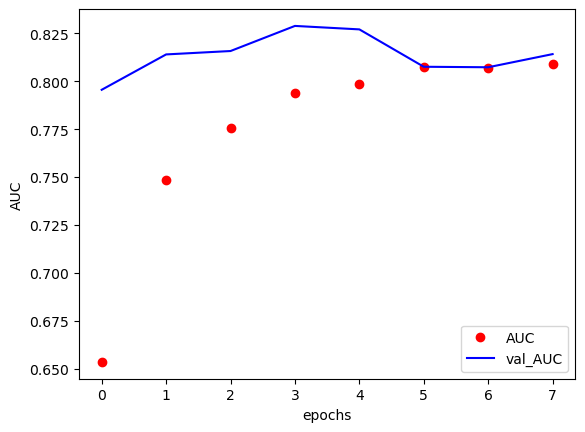

In [ ]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = simple_model.history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

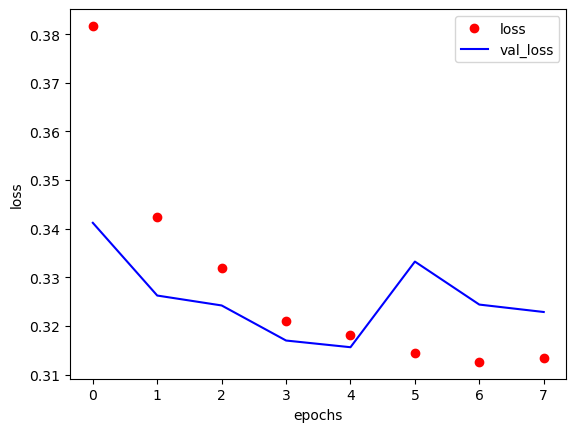

In [ ]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# test loss, acc, auc 구하기1
test_loss, test_acc, test_auc = simple_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')


# auroc 구하기2
from sklearn.metrics import roc_auc_score

test_pred = simple_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 2ms/step - loss: 0.2889 - acc: 0.8825 - auc: 0.8513
test_acc: 0.8825
test_auc: 0.8513
13/13 [==============================] - 0s 2ms/step
acc_test: 0.8825
auc_score_test: 0.8510


In [ ]:
simple_model.save(path+'simple_model_best_upto.h5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score

# model_name
# 'simple_model_best_upto.h5'
loaded_model = load_model(path+model_name)

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 2ms/step
acc_test: 0.8700
auc_score_test: 0.7922


### 어떻게 checkpoint 건 결과가 더 안좋게 나오지??

In [ ]:
y_test_3d

0        0.0
70       0.0
140      0.0
210      0.0
280      0.0
        ... 
27650    0.0
27720    0.0
27790    1.0
27860    0.0
27930    0.0
Name: labels, Length: 400, dtype: float64

In [ ]:
test_df.drop_duplicates(['pid'])

pid   age  Gender   ALP   ALT   AST  Albumin   BUN  Bilirubin  \
0      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
70     142245.0  86.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
140    137989.0  63.0     0.0   0.0   0.0   0.0      0.0   0.0        0.0   
210    142184.0  74.0     0.0  85.0  45.0  72.0      2.9  20.0        0.8   
280    134318.0  48.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
...         ...   ...     ...   ...   ...   ...      ...   ...        ...   
27650  139907.0  39.0     0.0  85.0  45.0  72.0      2.9  20.0        0.8   
27720  136230.0  75.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
27790  139358.0  71.0     1.0  85.0  45.0  72.0      2.9  20.0        0.8   
27860  137755.0  81.0     0.0  85.0  45.0  72.0      2.9  20.0        0.8   
27930  135219.0  78.0     0.0   0.0   0.0   0.0      0.0   0.0        0.0   

       Cholesterol  ...   MBP  male  female  surv_los   LOS  labels  \
0              0.0  ...   0.0   1.0     0.0      -7.0   6.0     0.0   
70             0.0  ...   0.0   1.0     0.0      -8.0   7.0     0.0   
140            0.0  ...   0.0   1.0     0.0     541.0  47.0     0.0   
210          143.5  ...  77.0   1.0     0.0     -38.0  37.0     0.0   
280            0.0  ...   0.0   1.0     0.0     -15.0  14.0     0.0   
...            ...  ...   ...   ...     ...       ...   ...     ...   
27650        143.5  ...  77.0   1.0     0.0     -85.0  84.0     0.0   
27720          0.0  ...   0.0   1.0     0.0     -10.0   9.0     0.0   
27790        143.5  ...  77.0   1.0     0.0      -2.0  28.0     1.0   
27860        143.5  ...  77.0   1.0     0.0      59.0  14.0     0.0   
27930          0.0  ...   0.0   1.0     0.0    2002.0   9.0     0.0   

       ICUType_1.0  ICUType_2.0  ICUType_3.0  ICUType_4.0  
0                0            0            1            0  
70               0            1            0            0  
140              0            0            1            0  
210              0            0            0            1  
280              0            0            1            0  
...            ...          ...          ...          ...  
27650            0            0            0            1  
27720            1            0            0            0  
27790            0            0            0            1  
27860            0            1            0            0  
27930            0            0            0            1  

[400 rows x 46 columns]

In [ ]:
test_pred[i][0]

0.06735104

In [ ]:
test_df['cnn_pred_30'] = 0.0
test_df['label'] = y_test
for i, pid in enumerate(list(test_df.pid.unique())):
    test_df.loc[test_df.query('pid==@pid').index, 'pred'] = test_pred[i][0]


In [ ]:
roc_auc_score(test_df['label'], test_df['pred'])

0.7922192749778957

In [ ]:
drop_df = test_df.drop_duplicates('pid')

In [ ]:
roc_auc_score(drop_df['label'], drop_df['pred'])

0.7922192749778957

In [ ]:
test_df

pid   age  Gender   ALP   ALT   AST  Albumin   BUN  Bilirubin  \
0      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
1      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
2      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
3      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
4      135089.0  90.0     1.0   0.0   0.0   0.0      0.0   0.0        0.0   
...         ...   ...     ...   ...   ...   ...      ...   ...        ...   
27995  135219.0  78.0     0.0  85.0  45.0  72.0      2.9  14.0        0.8   
27996  135219.0  78.0     0.0  85.0  45.0  72.0      2.9  14.0        0.8   
27997  135219.0  78.0     0.0  85.0  45.0  72.0      2.9  14.0        0.8   
27998  135219.0  78.0     0.0  85.0  45.0  72.0      2.9  14.0        0.8   
27999  135219.0  78.0     0.0  85.0  45.0  72.0      2.9  11.0        0.8   

       Cholesterol  ...  female  surv_los  LOS  labels  ICUType_1.0  \
0              0.0  ...     0.0      -7.0  6.0     0.0            0   
1              0.0  ...     0.0      -7.0  6.0     0.0            0   
2              0.0  ...     0.0      -7.0  6.0     0.0            0   
3              0.0  ...     0.0      -7.0  6.0     0.0            0   
4              0.0  ...     0.0      -7.0  6.0     0.0            0   
...            ...  ...     ...       ...  ...     ...          ...   
27995        143.5  ...     0.0    2002.0  9.0     0.0            0   
27996        143.5  ...     0.0    2002.0  9.0     0.0            0   
27997        143.5  ...     0.0    2002.0  9.0     0.0            0   
27998        143.5  ...     0.0    2002.0  9.0     0.0            0   
27999        143.5  ...     0.0    2002.0  9.0     0.0            0   

       ICUType_2.0  ICUType_3.0  ICUType_4.0      pred  label  
0                0            1            0  0.201459    0.0  
1                0            1            0  0.201459    0.0  
2                0            1            0  0.201459    0.0  
3                0            1            0  0.201459    0.0  
4                0            1            0  0.201459    0.0  
...            ...          ...          ...       ...    ...  
27995            0            0            1  0.067351    0.0  
27996            0            0            1  0.067351    0.0  
27997            0            0            1  0.067351    0.0  
27998            0            0            1  0.067351    0.0  
27999            0            0            1  0.067351    0.0  

[28000 rows x 48 columns]

In [ ]:
import seaborn as sns

/var/folders/j8/pjz_xxgx4xqdv4jz1jkf7nmc0000gn/T/ipykernel_84540/1335491014.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(drop_df['pred'].values)


<AxesSubplot:ylabel='Density'>

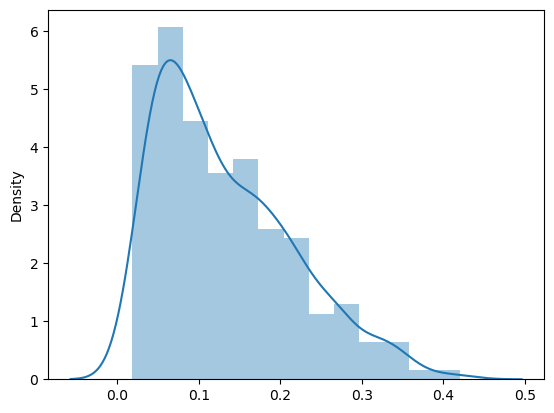

In [ ]:
sns.distplot(drop_df['pred'].values)

Text(0, 0.5, 'True Positive Rate(Positive label: 1)')

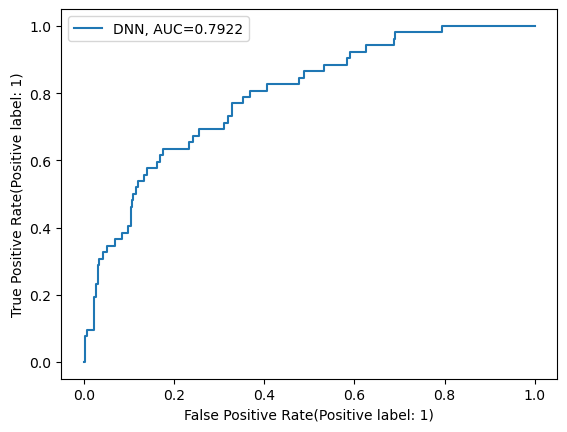

In [ ]:
# Simple Dense Model roc_curve와 SOFA roc_curve 비교하기

from sklearn.metrics import roc_curve, roc_auc_score
real_mean = drop_df['label'].values
pred_mean = drop_df['pred'].values

fpr_sofa, tpr_sofa, thr = roc_curve(real_mean, pred_mean)
sofa_auc = round(roc_auc_score(real_mean, pred_mean), 4)
plt.plot(fpr_sofa, tpr_sofa, label="DNN, AUC="+str(sofa_auc))

plt.legend()
plt.xlabel('False Positive Rate(Positive label: 1)')
plt.ylabel('True Positive Rate(Positive label: 1)')



In [ ]:
thr[fpr_sofa>0.7]

array([0.0523594 , 0.05226867, 0.01879093])

In [ ]:
thr[(tpr_sofa>0.9) & (fpr_sofa>0.9)]

array([0.01879093])

In [ ]:
cut = 0.2

In [ ]:
drop_df.query('pred>=@cut and label==1').LOS.mean()

13.129032258064516

In [ ]:
drop_df.query('pred<@cut and label==1').LOS.mean()

12.80952380952381

In [ ]:
drop_df[['pred', 'LOS', 'RR', 'Gender', 'label']].corr()

pred       LOS        RR    Gender     label
pred    1.000000  0.166889  0.236181  0.010665  0.379111
LOS     0.166889  1.000000  0.131496 -0.003427 -0.015716
RR      0.236181  0.131496  1.000000  0.057288  0.061910
Gender  0.010665 -0.003427  0.057288  1.000000  0.001504
label   0.379111 -0.015716  0.061910  0.001504  1.000000

In [ ]:
condition bad -> stay longer

In [ ]:
drop_df.query('pred>@cut and label==0').LOS.mean()

17.228070175438596

In [ ]:
drop_df.query('pred<=@cut and label==0').LOS.mean()

12.84192439862543

In [ ]:
drop_df.columns

Index(['pid', 'age', 'Gender', 'ALP', 'ALT', 'AST', 'Albumin', 'BUN',
       'Bilirubin', 'Cholesterol', 'Creatinine', 'FiO2', 'GCS', 'Glucose',
       'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'Na', 'PaCO2', 'PaO2',
       'Platelets', 'RR', 'SPO2', 'BT', 'TroponinI', 'TroponinT', 'Urine',
       'WBC', 'pH', 'MechVent', 'survival', 'SBP', 'DBP', 'MBP', 'male',
       'female', 'surv_los', 'LOS', 'labels', 'ICUType_1.0', 'ICUType_2.0',
       'ICUType_3.0', 'ICUType_4.0', 'pred', 'label'],
      dtype='object')

In [ ]:
drop_df = drop_df.rename(columns = {
    "ICUType_1.0":"ICUType_1",
    "ICUType_2.0": "ICUType_2",
    "ICUType_3.0": "ICUType_3",
    "ICUType_4.0": "ICUType_4"
})

In [ ]:
drop_df["ICUType_1.0`"]

0        0
70       0
140      0
210      0
280      0
        ..
27650    0
27720    1
27790    0
27860    0
27930    0
Name: ICUType_1.0, Length: 400, dtype: int64

1 0.0    45
1.0     5
Name: label, dtype: int64
2 0.0    80
1.0     6
Name: label, dtype: int64
3 0.0    124
1.0     30
Name: label, dtype: int64
4 0.0    99
1.0    11
Name: label, dtype: int64


Text(0, 0.5, 'True Positive Rate(Positive label: 1)')

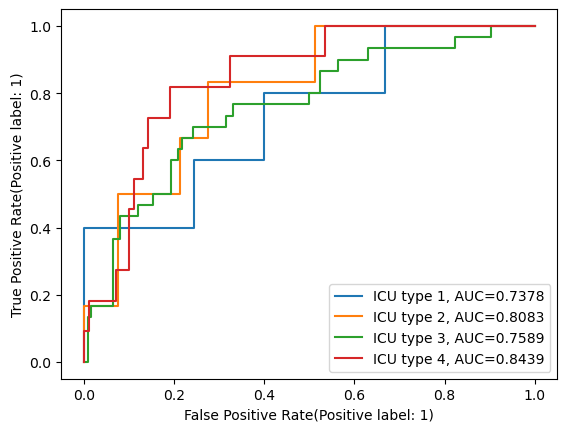

In [ ]:
for i in range(1, 5):
    icu_df = drop_df.query(f"ICUType_{i}==1")
    print(i, icu_df.label.value_counts())
    # Simple Dense Model roc_curve와 SOFA roc_curve 비교하기

    real_mean = icu_df['label'].values
    pred_mean = icu_df['pred'].values

    fpr_sofa, tpr_sofa, thr = roc_curve(real_mean, pred_mean)
    sofa_auc = round(roc_auc_score(real_mean, pred_mean), 4)
    plt.plot(fpr_sofa, tpr_sofa, label=f"ICU type {i}, AUC="+str(sofa_auc))

plt.legend()
plt.xlabel('False Positive Rate(Positive label: 1)')
plt.ylabel('True Positive Rate(Positive label: 1)')



In [ ]:
ICUType (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit,
3: Medical ICU, or 4: Surgical ICU)

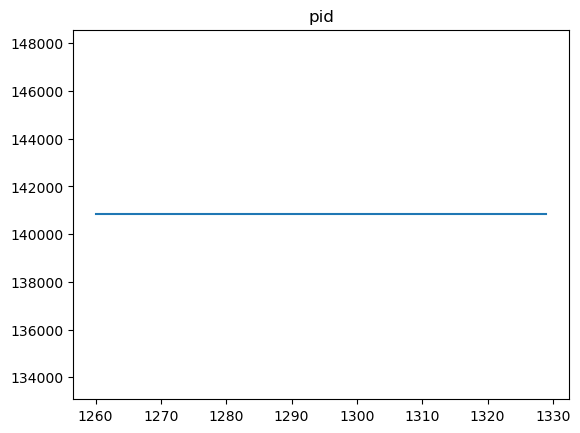

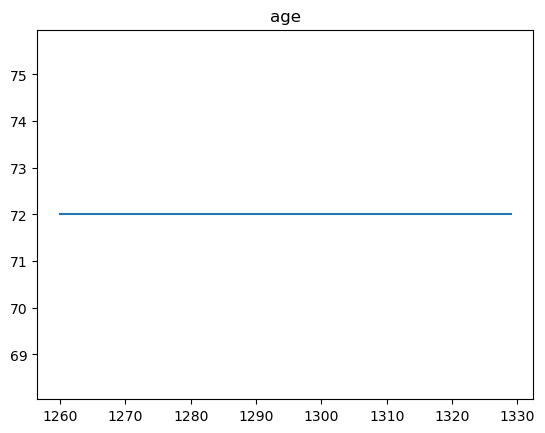

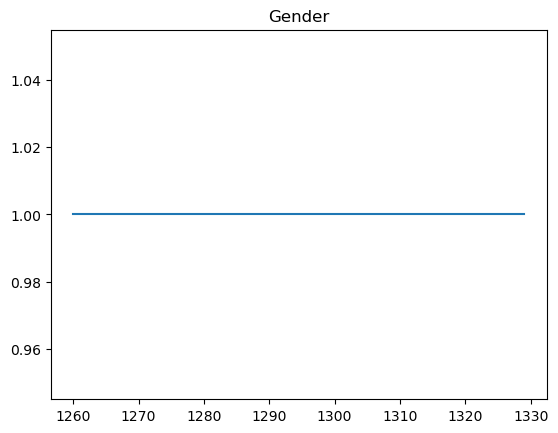

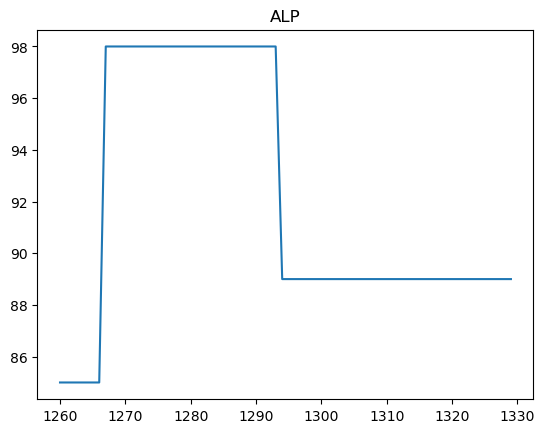

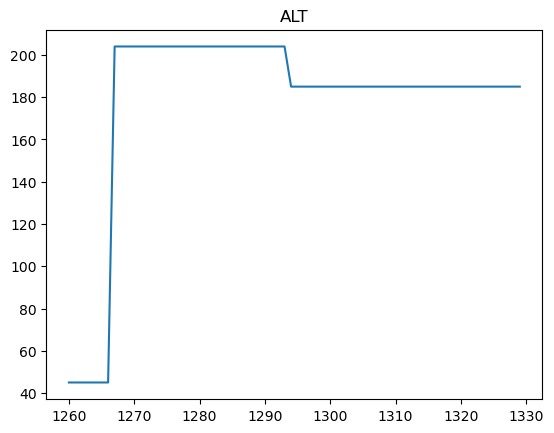

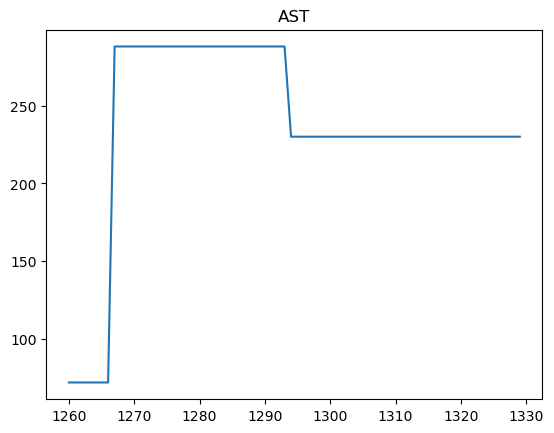

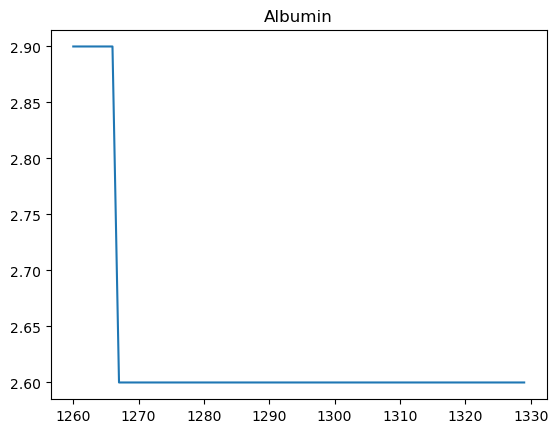

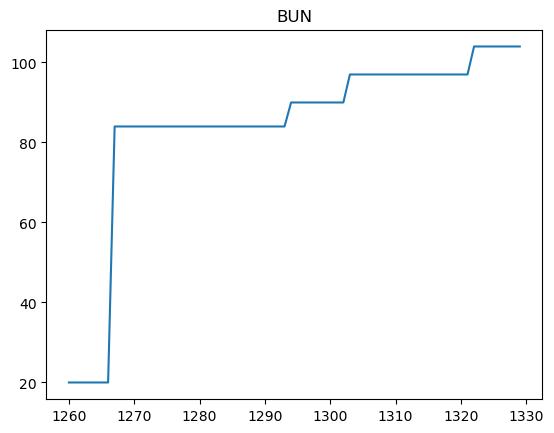

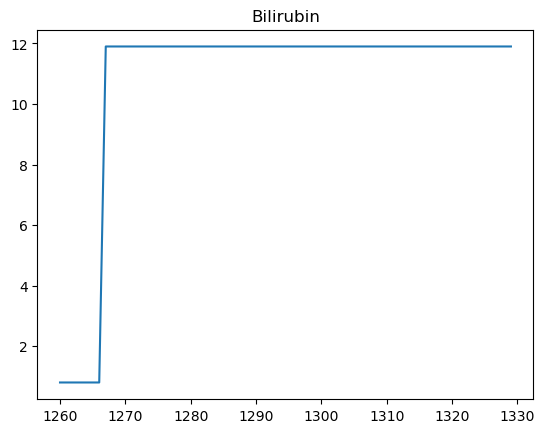

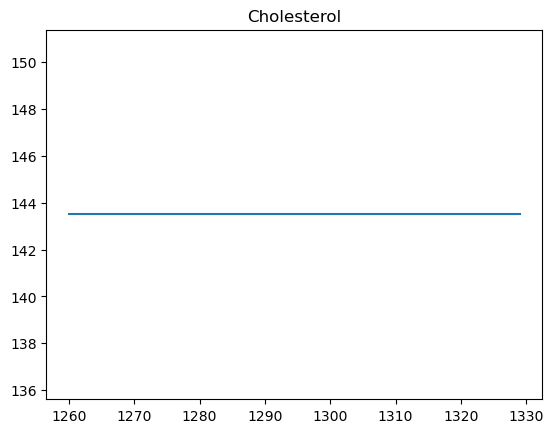

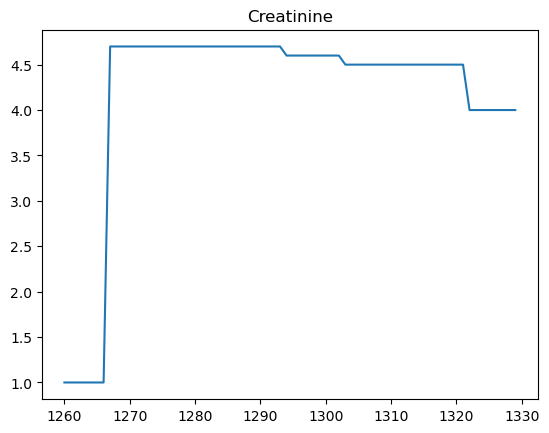

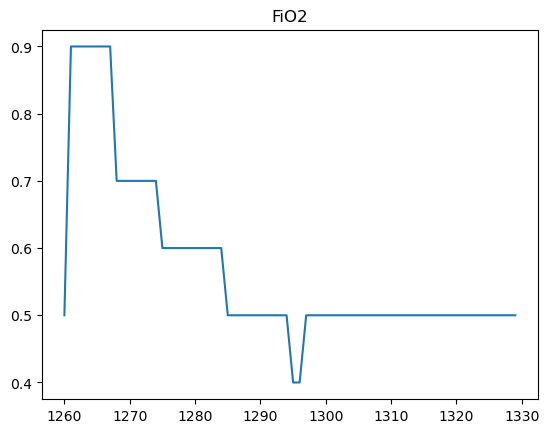

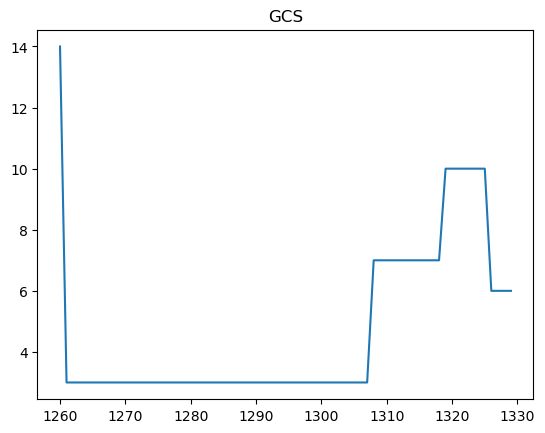

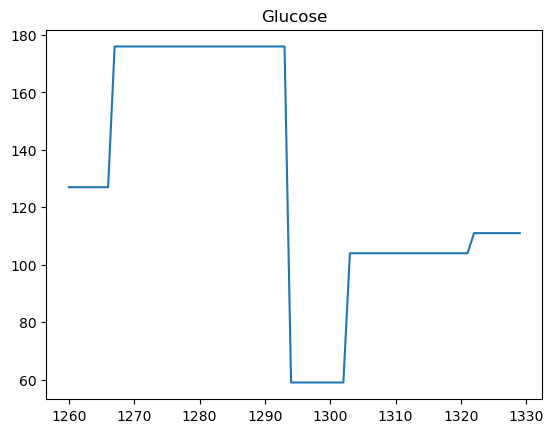

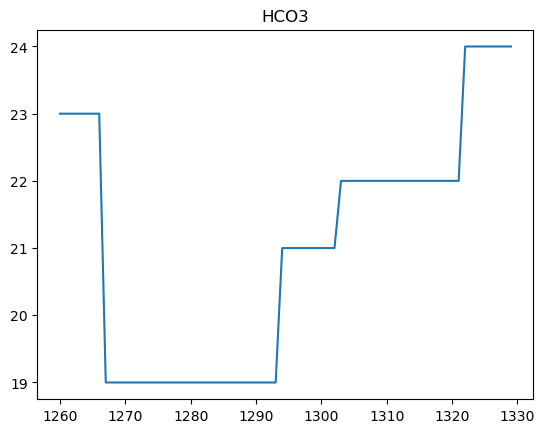

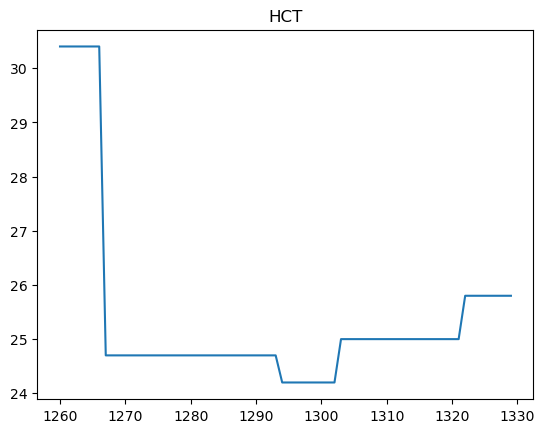

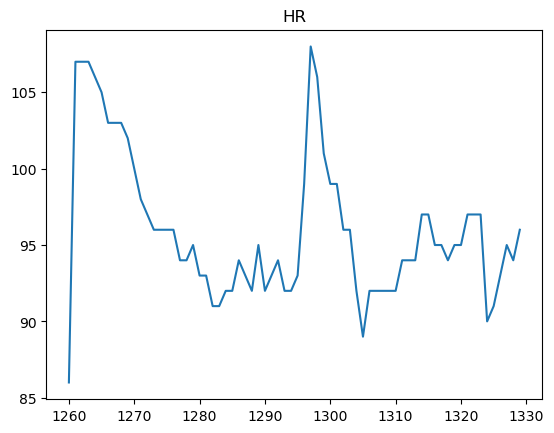

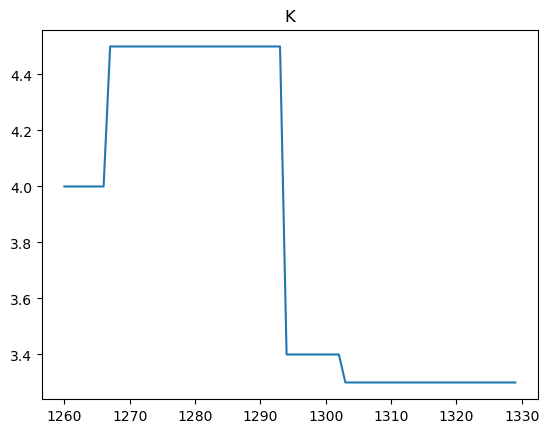

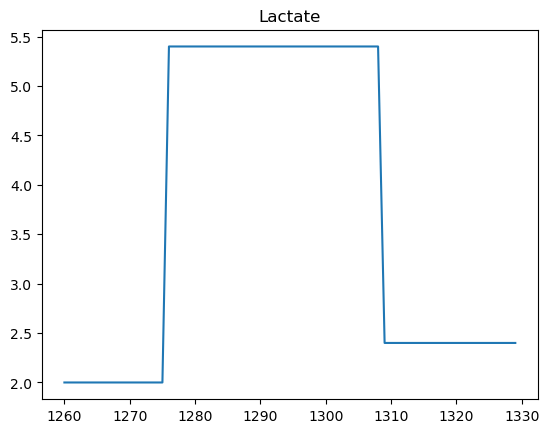

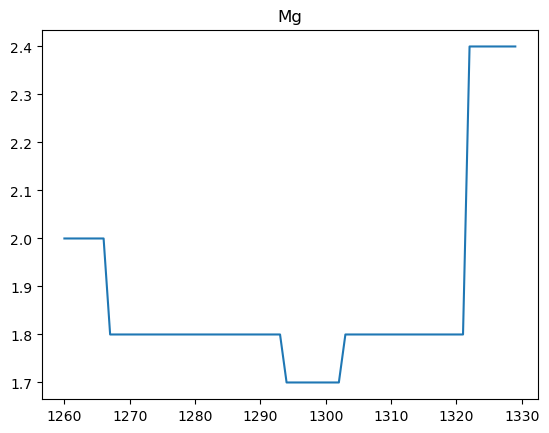

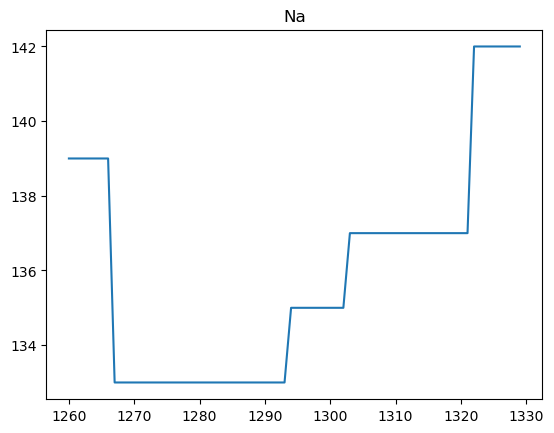

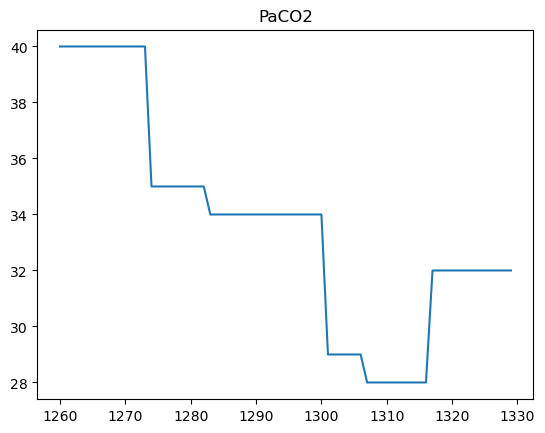

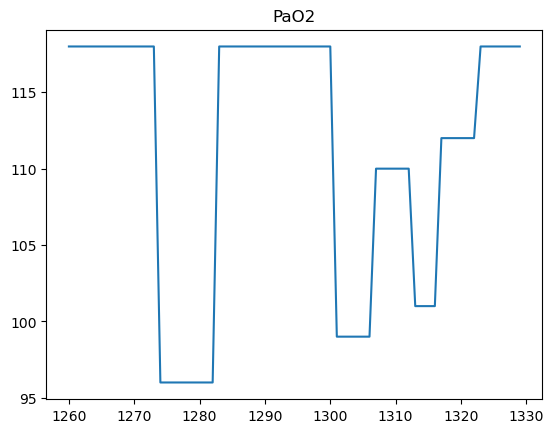

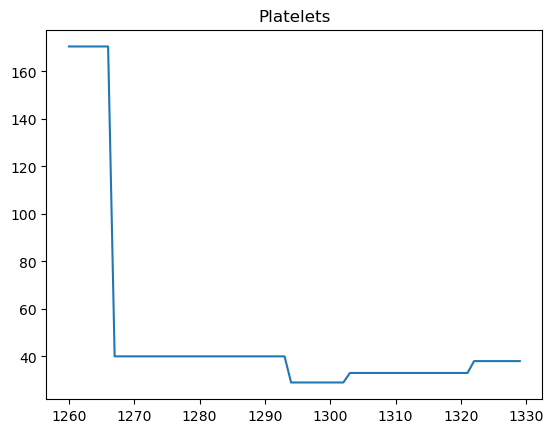

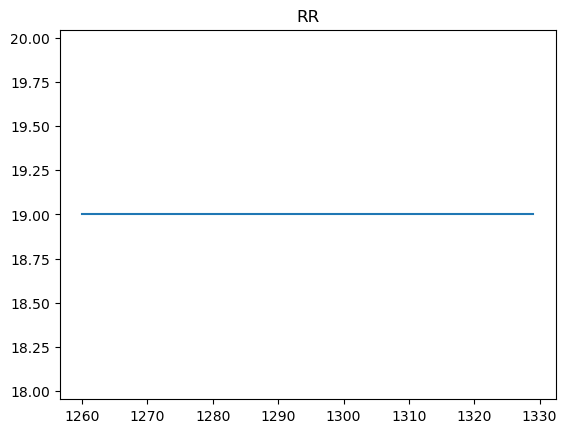

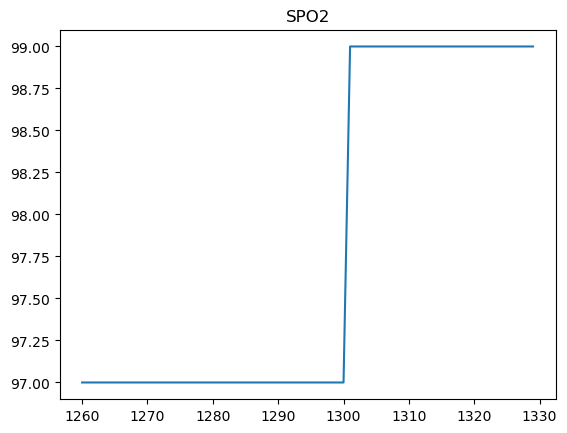

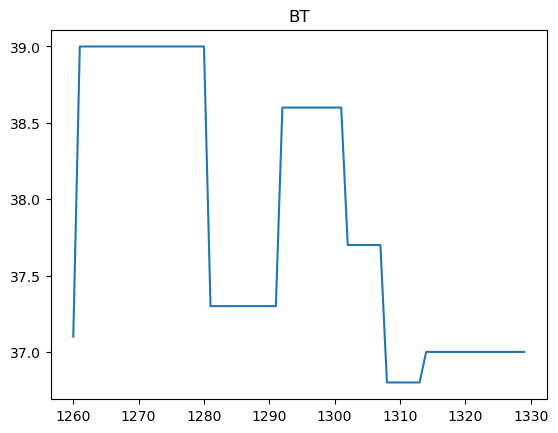

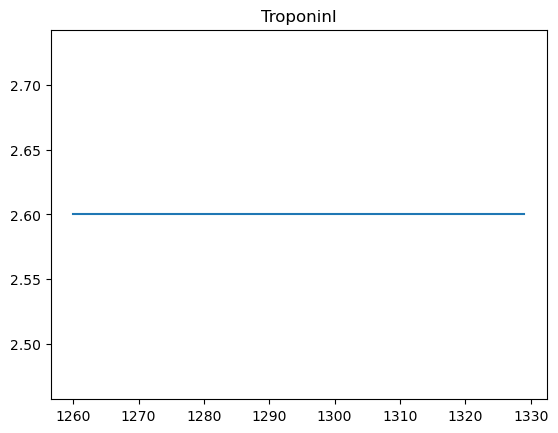

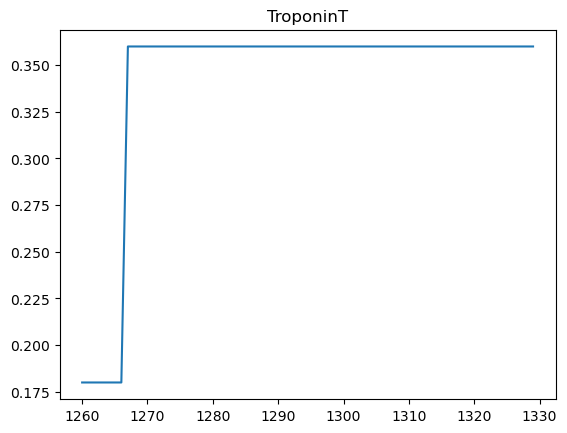

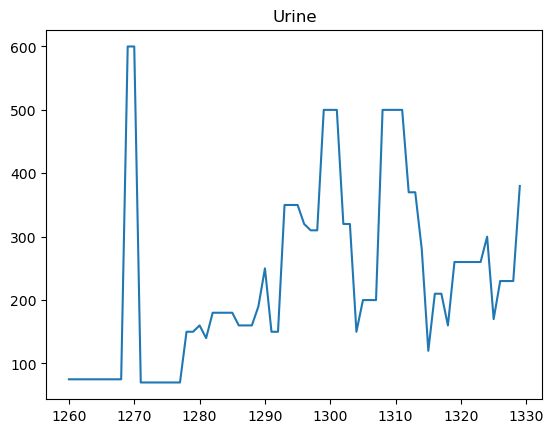

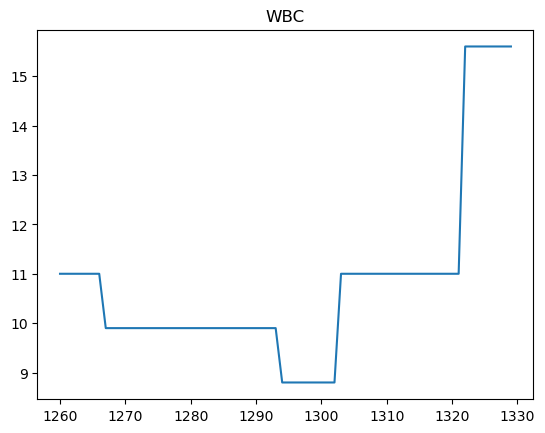

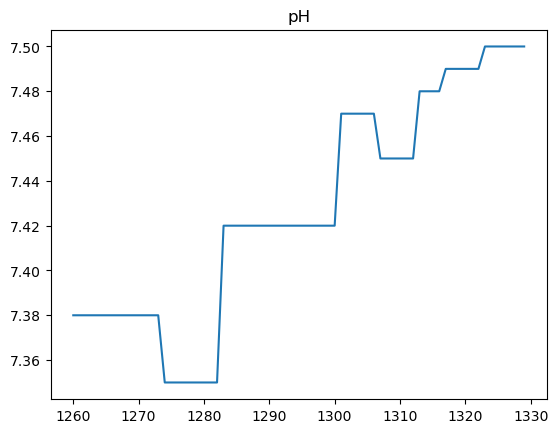

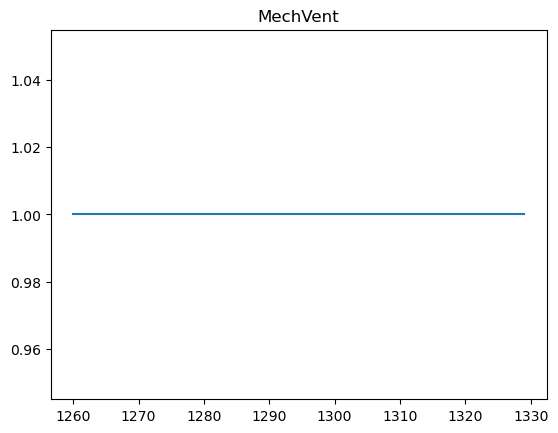

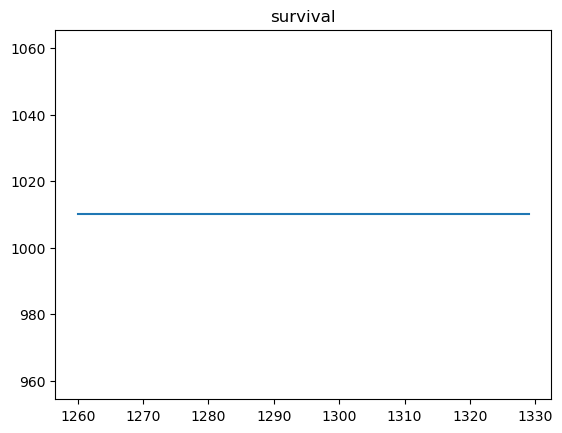

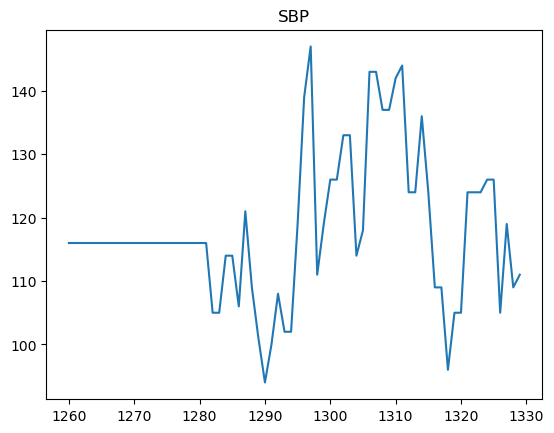

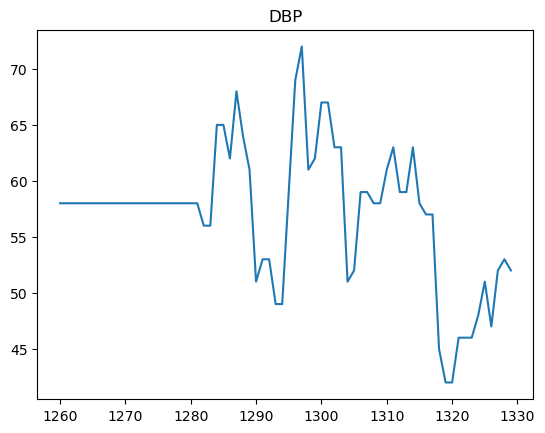

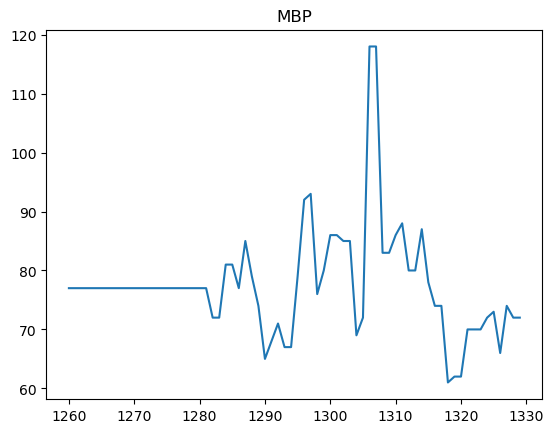

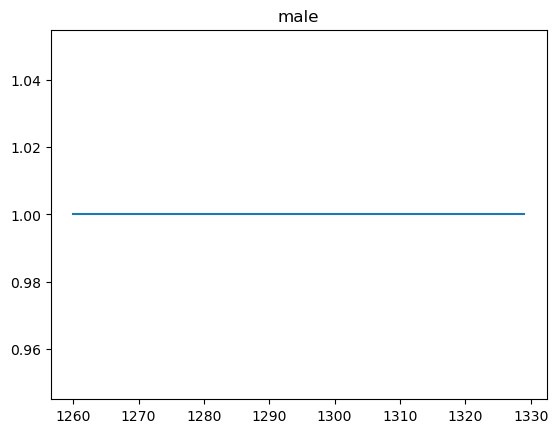

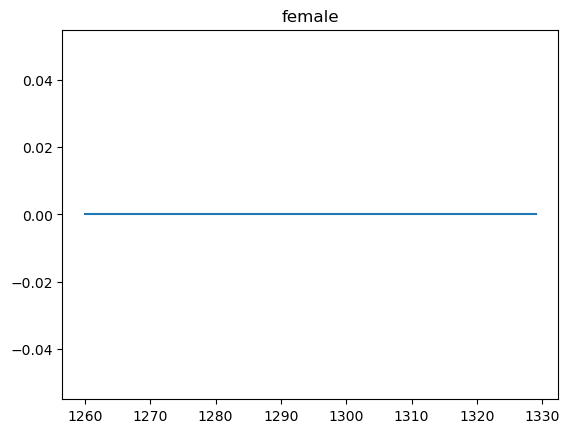

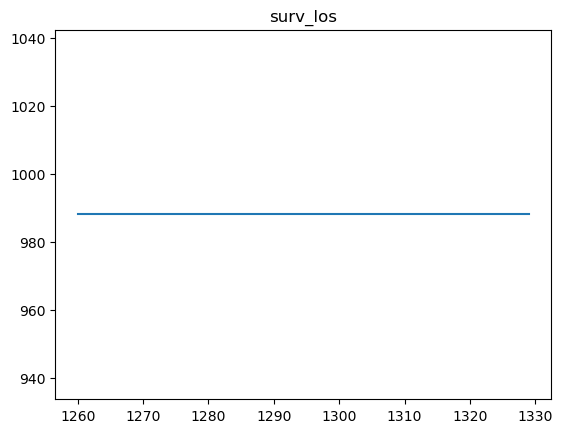

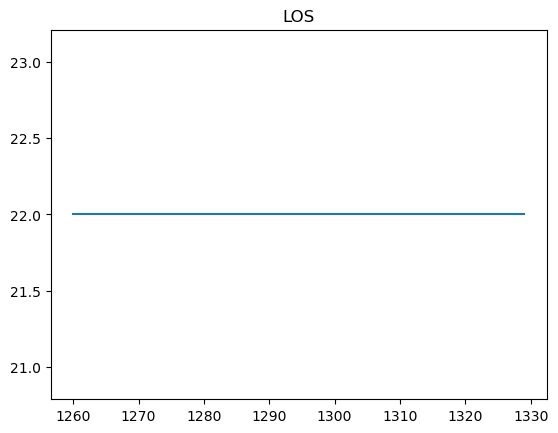

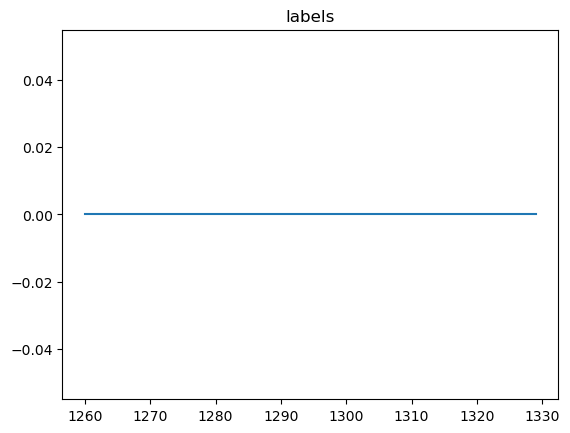

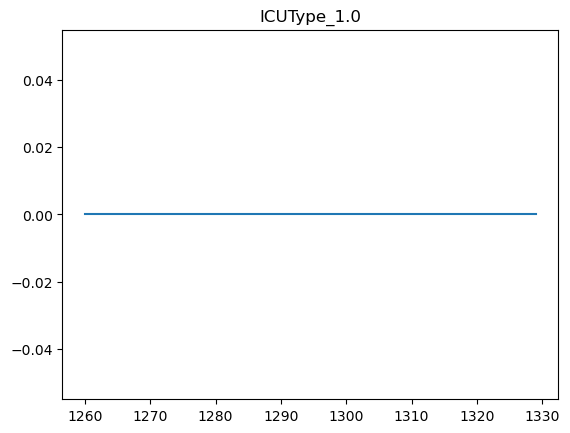

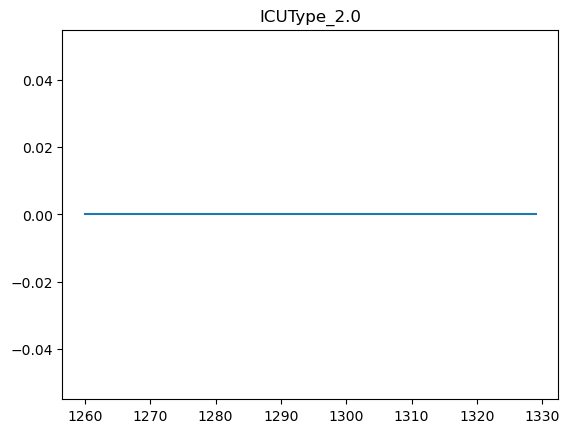

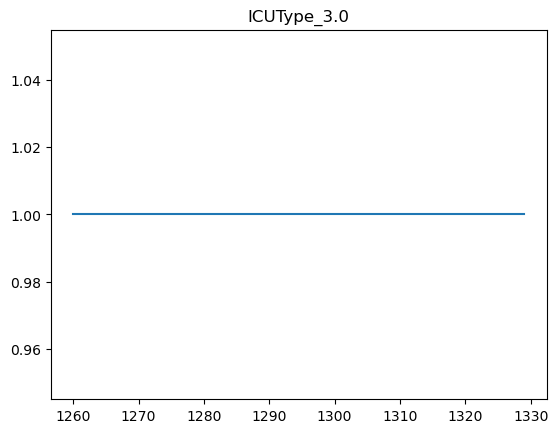

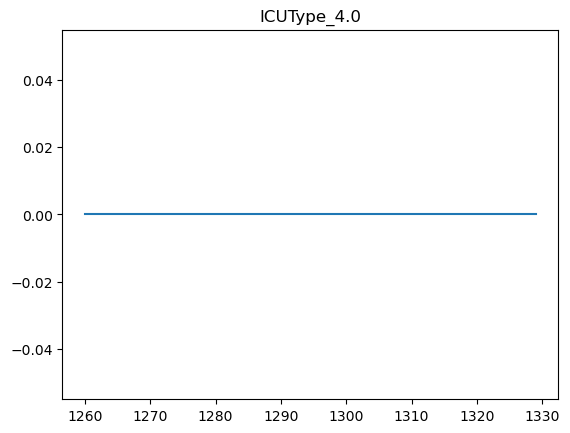

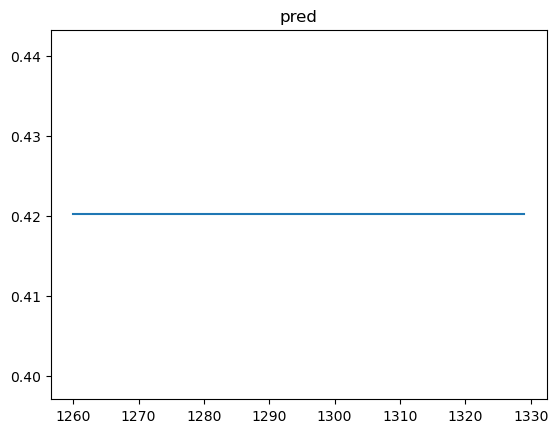

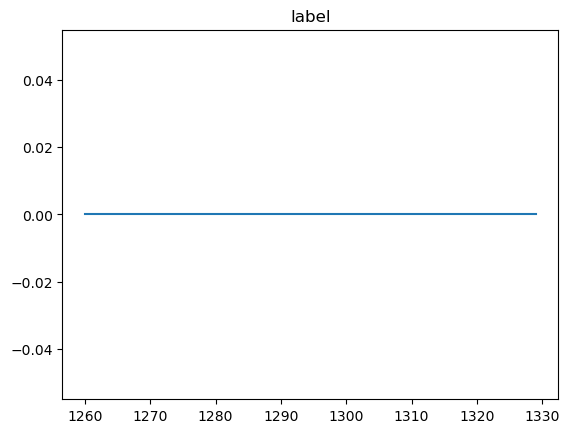

In [ ]:
for col in test_df.columns:
    plt.title(col)
    plt.plot(test_df.query('pid==140821.0')[col])
#    plt.plot(test_df[col].mean())
    plt.show()